In [1]:
import pandas as pd
import numpy as np
import random
import re
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 100
NUM_CLASSES = 7
BATCH_SIZE = 32
EPOCHS = 80
TEST_BATCH_SIZE = 32

In [3]:
# The training images_path are stored in the training_images_path list
training_images_path = []
# The training labels are stored in the training_labels list
training_labels = []
# The testing images_path are stored in the testing_images_path list
testing_images_path = []
# The testing labels are stored in the testing_labels list
testing_labels = []

path = "./archive"
for directory in os.listdir(path):
    if not directory.startswith('.'):
        images_path = []
        labels =[]
        for img in os.listdir(os.path.join(path,directory)):
            if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
                img_path = os.path.join(os.path.join(path,directory),img)
                images_path.append(img_path)
                labels.append(directory)
        # Split the images_path into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(images_path, labels, test_size=0.1, random_state=42)
        training_images_path.extend(X_train)
        training_labels.extend(y_train)
        testing_images_path.extend(X_test)
        testing_labels.extend(y_test)
        print(f"Directory: {directory}, Training images: {len(X_train)}, Testing images: {len(X_test)}")

Directory: Big Truck, Training images: 519, Testing images: 58
Directory: City Car, Training images: 4191, Testing images: 466
Directory: Multi Purpose Vehicle, Training images: 2384, Testing images: 265
Directory: Sedan, Training images: 2357, Testing images: 262
Directory: Sport Utility Vehicle, Training images: 1643, Testing images: 183
Directory: Truck, Training images: 1035, Testing images: 115
Directory: Van, Training images: 1950, Testing images: 217


In [4]:
# Create training and testing DataFrame to store the images_path and labels
training_df = pd.DataFrame({'images_path': training_images_path, 'labels': training_labels})
testing_df = pd.DataFrame({'images_path': testing_images_path, 'labels': testing_labels})
training_df.shape, testing_df.shape

# shuffle the training DataFrame
training_df = training_df.sample(frac=1).reset_index(drop=True)

In [5]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_data_gen = ImageDataGenerator(
    rescale=1./255
)

In [6]:
# Create the training, validation and testing generators
train_generator = train_data_gen.flow_from_dataframe(
train_generator = train_data_gen.flow_from_dataframe(
    training_df,
    x_col='images_path',
    y_col='labels',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training'
)

validation_generator = train_data_gen.flow_from_dataframe(
    training_df,
    x_col='images_path',
    y_col='labels',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation'
)

test_generator = test_data_gen.flow_from_dataframe(
    testing_df,
    x_col='images_path',
    y_col='labels',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11264 validated image filenames belonging to 7 classes.
Found 2815 validated image filenames belonging to 7 classes.
Found 1566 validated image filenames belonging to 7 classes.


In [7]:
# Create the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [10]:
# Fit the model with the updated generators
predictor = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=[callback])

Epoch 1/80
  1/352 ━━━━━━━━━━━━━━━━━━━━ 7:02 1s/step - accuracy: 0.1875 - loss: 1.9699

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.3048 - loss: 1.7327 - val_accuracy: 0.4202 - val_loss: 1.3866
Epoch 2/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.4365 - loss: 1.3359 - val_accuracy: 0.5414 - val_loss: 1.0863
Epoch 3/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.5162 - loss: 1.1374 - val_accuracy: 0.6409 - val_loss: 0.9277
Epoch 4/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.5819 - loss: 1.0002 - val_accuracy: 0.6703 - val_loss: 0.8476
Epoch 5/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.6536 - loss: 0.8546 - val_accuracy: 0.7101 - val_loss: 0.7865
Epoch 6/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.6670 - loss: 0.7956 - val_accuracy: 0.7311 - val_loss: 0.6976
Epoch 7/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.7119 - loss: 0.7108 - val_accuracy: 0.7638 - val_loss: 0.6378
Epoch 8/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.7306 - loss: 0.6487 - val_accurac

In [11]:
# Print out the testing accuracy and loss
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8549 - loss: 0.6293
Test loss: 0.7137126326560974
Test accuracy: 0.8544061183929443


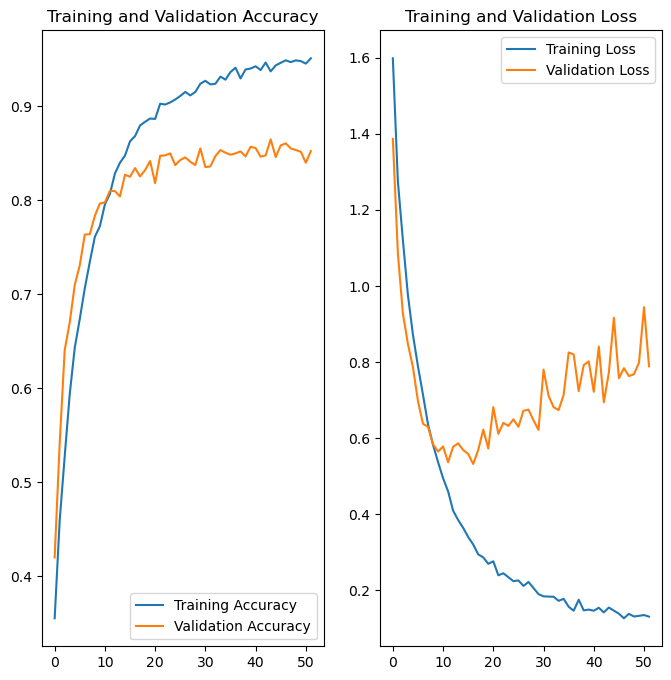

In [13]:
# Plot the training and validation accuracy and loss
accuracy = predictor.history['accuracy']
val_accuracy = predictor.history['val_accuracy']

loss = predictor.history['loss']
val_loss = predictor.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
label_names = list(train_generator.class_indices.keys())
print("All class labels:", label_names)

All class labels: ['Big Truck', 'City Car', 'Multi Purpose Vehicle', 'Sedan', 'Sport Utility Vehicle', 'Truck', 'Van']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Actual Vehicle Type: Multi Purpose Vehicle
Predicted Vehicle Type: Multi Purpose Vehicle


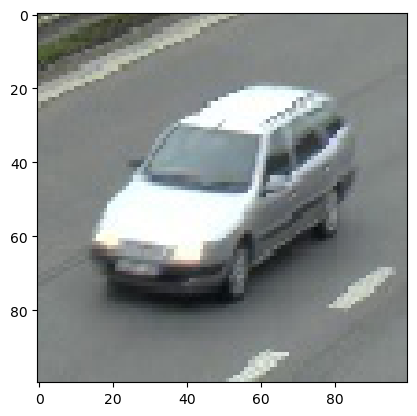

In [17]:
# Predict the vehicle type of a random image
img_num = random.randrange(0, 31)
gen_num = random.randrange(0, 47)

sample_img, sample_label = test_generator[gen_num]
prediction = model.predict(sample_img)
print("Actual Vehicle Type:", label_names[np.argmax(sample_label[img_num])])
print("Predicted Vehicle Type:", label_names[np.argmax(prediction[img_num])])

plt.imshow(sample_img[img_num])
plt.show()